In [ ]:
from dataset import *
from utils import *
from visualisation import *
from torchvision.utils import save_image
import os
import json
from types import SimpleNamespace
from train_feature_network import get_data
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from args import get_args

def autoplay_video(video_path):
    return HTML(f'<video src="{video_path}" controls autoplay loop muted playsinline style="max-width: 100%;"></video>')

def play_folder(folder):
    for video_file in [f for f in os.listdir(folder) if f.endswith(".mp4")][::-1]:
        video_path = os.path.join(folder, video_file)
        display(autoplay_video(video_path))

def save_video_and_frames(frames, folder_path, loop=False, fps=30, step=8):
    os.makedirs(folder_path, exist_ok=True)
    if type(frames) is list:
        frames = torch.cat(frames, dim=-1)
    for i, frame in enumerate(frames[::step]):
        save_image(frame[None], os.path.join(folder_path, f'frame_{i}.png'))
    save_video(frames, os.path.join(folder_path, f'video.mp4'), fps=fps, loop=loop)
    del frames
    torch.cuda.empty_cache()

def get_model(exp_path, args, device):
    with torch.no_grad():
        model, _, _, _ = get_feature_network(args, os.path.join(exp_path, 'feature_network.pt'))
        model = model.to(device)
    return model

# NOTE: Do not forget to change the paths if you are using the pre-trained models.
def get_dummy_args():
    return SimpleNamespace(**{
        "feature_dim": 2048,
        "device": "cuda",
        "exp_path": "experiments",
        "exp_name": "",
        "FN_path": "",
        "num_layers": 3,
        "smpl_data_path": "./data/SMPL_shape_dataset",
        "amass_path": "PATH/TO/AMASS/amass_30fps_train.pt",
        "smplh_path": "PATH/TO/smplh/neutral/model.npz",
        "deforming_things_path": "./data/DeformingThings4DFeatures",
        "smal_ours_data_path": "./data/SMAL_ours_shape_dataset",
        "shrec19_data_path": "./data/SHREC19_shape_dataset",
        "shrec20_data_path": "./data/SHREC20_shape_dataset",
        "tosca_data_path": "./data/TOSCA_shape_dataset",
        "shapnet_chair_data_path": "./data/shapenet_chair",
        "shapnet_chair_val_data_path": "./data/shapenet_chair_val",
        "shapnet_airplane_data_path": "./data/shapenet_airplane",
        "shapnet_airplane_val_data_path": "./data/shapenet_airplane_val",
        "shapnet_table_data_path": "./data/shapenet_table",
        "smal_data_path": "./data/SMAL_shape_dataset",
        "surreal_data_path": "./data/surreal_shape_dataset",
        "shapenet_data_path": "./data/shapenet",
        "polyhaven_chair_data_path": "./data/polyhaven_chairs",
        "polyhaven_animals_data_path": "./data/polyhaven_animals",
        "source_folder_dt4d": "PATH/TO/DeformingThings4D/animals", # Needed for the animations only
        "mask": None,
        "train_data": [
            ""
        ],
        "val_pairs": [
        ],
        "tensorboard_path": "",
        "train_on_validation": True,
        "seed": 0,
        "feature_noise_p": 0.0,
        "fps_p": 100,
        "FN_lr": 0.0001,
        "w_contrastive": 1,
        "w_reconstruction": 1,
        "FN_iters": 5000,
        "FN_render_iter": 500,
        "FN_train": True
    })

Unable to load the following plugins:

	libfilter_embree.so: libfilter_embree.so does not seem to be a Qt Plugin.

Cannot load library /home/lukas/miniconda3/envs/kd_new/lib/python3.10/site-packages/pymeshlab/lib/plugins/libfilter_embree.so: (/home/lukas/miniconda3/envs/kd_new/lib/python3.10/site-packages/pymeshlab/lib/plugins/../libembree4.so.4: undefined symbol: _ZN3tbb10interface78internal20isolate_within_arenaERNS1_13delegate_baseEl)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 565.57.01


/home/lukas/miniconda3/envs/kd_new/lib/python3.10/site-packages/diffusers/models/unet_2d_blocks.py:249: FutureWarning: `AutoencoderTinyBlock` is deprecated and will be removed in version 0.29. Importing `AutoencoderTinyBlock` from `diffusers.models.unet_2d_blocks` is deprecated and this will be removed in a future version. Please use `from diffusers.models.unets.unet_2d_blocks import AutoencoderTinyBlock`, instead.
  deprecate("AutoencoderTinyBlock", "0.29", deprecation_message)
/home/lukas/miniconda3/envs/kd_new/lib/python3.10/site-packages/diffusers/models/unet_2d_blocks.py:254: FutureWarning: `UNetMidBlock2D` is deprecated and will be removed in version 0.29. Importing `UNetMidBlock2D` from `diffusers.models.unet_2d_blocks` is deprecated and this will be removed in a future version. Please use `from diffusers.models.unets.unet_2d_blocks import UNetMidBlock2D`, instead.
  deprecate("UNetMidBlock2D", "0.29", deprecation_message)
/home/lukas/miniconda3/envs/kd_new/lib/python3.10/site-p

# Choose Weights

In [2]:
device = 'cuda'
custom_model = False

if custom_model:
    exp_path = './experiments/CUSTOM_MODEL'
    with open(os.path.join(exp_path, 'args.json'), 'r') as f:
        args = SimpleNamespace(**json.load(f))
    model = get_model(exp_path, args, device)
else:
    exp_path = 'application_results'
    args = get_dummy_args()
    model_humans_animals = get_model('./experiments/humans_animals', args, device)
    model_all_shapes = get_model('./experiments/all_shapes', args, device)

Checkpoint loaded from ./experiments/humans_animals/feature_network.pt (iter 13500)
Checkpoint loaded from ./experiments/all_shapes/feature_network.pt (iter 89000)


# Initialize Datasets
Allows for easy mix and matching inbetween them :)

In [3]:
data_chairs, _ = DATA['polyhaven_chair'](args)
data_animals, _ = DATA['polyhaven_animals'](args)
data_smal_dummy, smal_weights = DATA['smal_dummy'](args)

# If you have the other datasets preprocessed, you can add them the followin way:
# data_dt4d, _ = DATA['dt4d'](args)
# data_tosca, _ = DATA['tosca'](args)
# data_shrec19 = DATA['shrec19'](args)
# data_shrec20 = DATA['shrec20'](args)
# data_chair_val, _ = DATA['shapenet_chair_val'](args)
# data_smal_ours, _ = DATA['smal_ours'](args)
# ...

# Point-to-Point Correspondences

In [13]:
data1 = data_chairs
data2 = data_chairs
exp_name = 'chair_to_chair'

src_i = 1
tgt_i = 2

render_folder = os.path.join(exp_path, 'correspondences', exp_name, f'correspondence_cos_{src_i}s-{tgt_i}t')
v_src, f_src, feat_src, Feat_src, _, _ = get_data(model_all_shapes, data1, src_i)
v_tgt, f_tgt, feat_tgt, Feat_tgt, _, _ = get_data(model_all_shapes, data2, tgt_i)

surface_map_cos = get_point_correspondences(feat_src, feat_tgt)
surface_map_cos_diff3f = get_point_correspondences(Feat_src, Feat_tgt)

num_frames = 120
fmap_img = get_correspondence_img(v_src, f_src, v_tgt, f_tgt, surface_map_cos, num_frames=num_frames, joint=False)
fmap_img_diff3f = get_correspondence_img(v_src, f_src, v_tgt, f_tgt, surface_map_cos_diff3f, num_frames=num_frames, skip_src_render=True, joint=False)
fmap_img = torch.concat([fmap_img, fmap_img_diff3f], dim=-1)

save_video_and_frames(fmap_img, render_folder, loop=False)
print('Source | ', 'Target Ours | ', 'Target Diff3F')
play_folder(render_folder)

[libx264 @ 0x2e9fabc0] -qscale is ignored, -crf is recommended.


Source |  Target Ours |  Target Diff3F


# Feature Clustering

## Transfer Clusters
Calculate centroids based on one shape and predict clusters on another

In [14]:
# Transfer clustering
num_components = 8
src_i = 1
tgt_i = 2
diff3f = False

data1 = data_smal_dummy
data2 = data_chairs 

for diff3f in [False, True]:
    exp = 'ours' if not diff3f else 'diff3f'
    print(f'Experiment: {exp}')
    pred_clustering_path = os.path.join(exp_path, 'pred_clustering', exp, f'{src_i}_to_{tgt_i}_components{num_components}')
    os.makedirs(pred_clustering_path, exist_ok=True)
    frames_ours = get_predictive_clustering_img(num_components, model_all_shapes, data1, data2, src_i, tgt_i, diff3d=diff3f, num_frames=120)
    save_video_and_frames(frames_ours, pred_clustering_path, loop=False)
    play_folder(pred_clustering_path)

Experiment: ours


[libx264 @ 0x2f2ffbc0] -qscale is ignored, -crf is recommended.


Experiment: diff3f


[libx264 @ 0x41dc7bc0] -qscale is ignored, -crf is recommended.


## Dataset Clustering
Calculate centroids based on a whole dataset and then find the NN for a few shapes. Note that clustering with Diff3F features is quite slow. It also takes a lot of memory.

In [15]:
# Based on features of whole data set
num_components = 8
indices = [0, 1, 2, 3, 4] 

for diff3f in [False, True]:
    exp = 'ours' if not diff3f else 'diff3f'
    print(f'Experiment: {exp}')
    clustering_path = os.path.join(exp_path, 'whole_dataset_clustering', exp)
    os.makedirs(clustering_path, exist_ok=True)
    img_ours, cols_ours, centroids, feat = get_whole_dataset_clustering_img(
        num_components,
        model_humans_animals,
        data_smal_dummy,
        indices,
        diff3d=diff3f,
        num_frames=120
    )
    del feat
    torch.cuda.empty_cache()

    file_path = os.path.join(clustering_path, f'{num_components}_{",".join([str(i) for i in indices])}')
    save_video_and_frames(img_ours, file_path, loop=False, fps=30)
    play_folder(file_path)

Experiment: ours


[libx264 @ 0x245d8bc0] -qscale is ignored, -crf is recommended.


Experiment: diff3f


[libx264 @ 0x3218fbc0] -qscale is ignored, -crf is recommended.


# PCA
Calculates the PCA on the SMAL dummy dataset features and visualizes the PCA embedding with the pseudo labels stemming from the skinning weights.

Shape 1 | Shape 2 | PCA Ours | PCA Diff3F


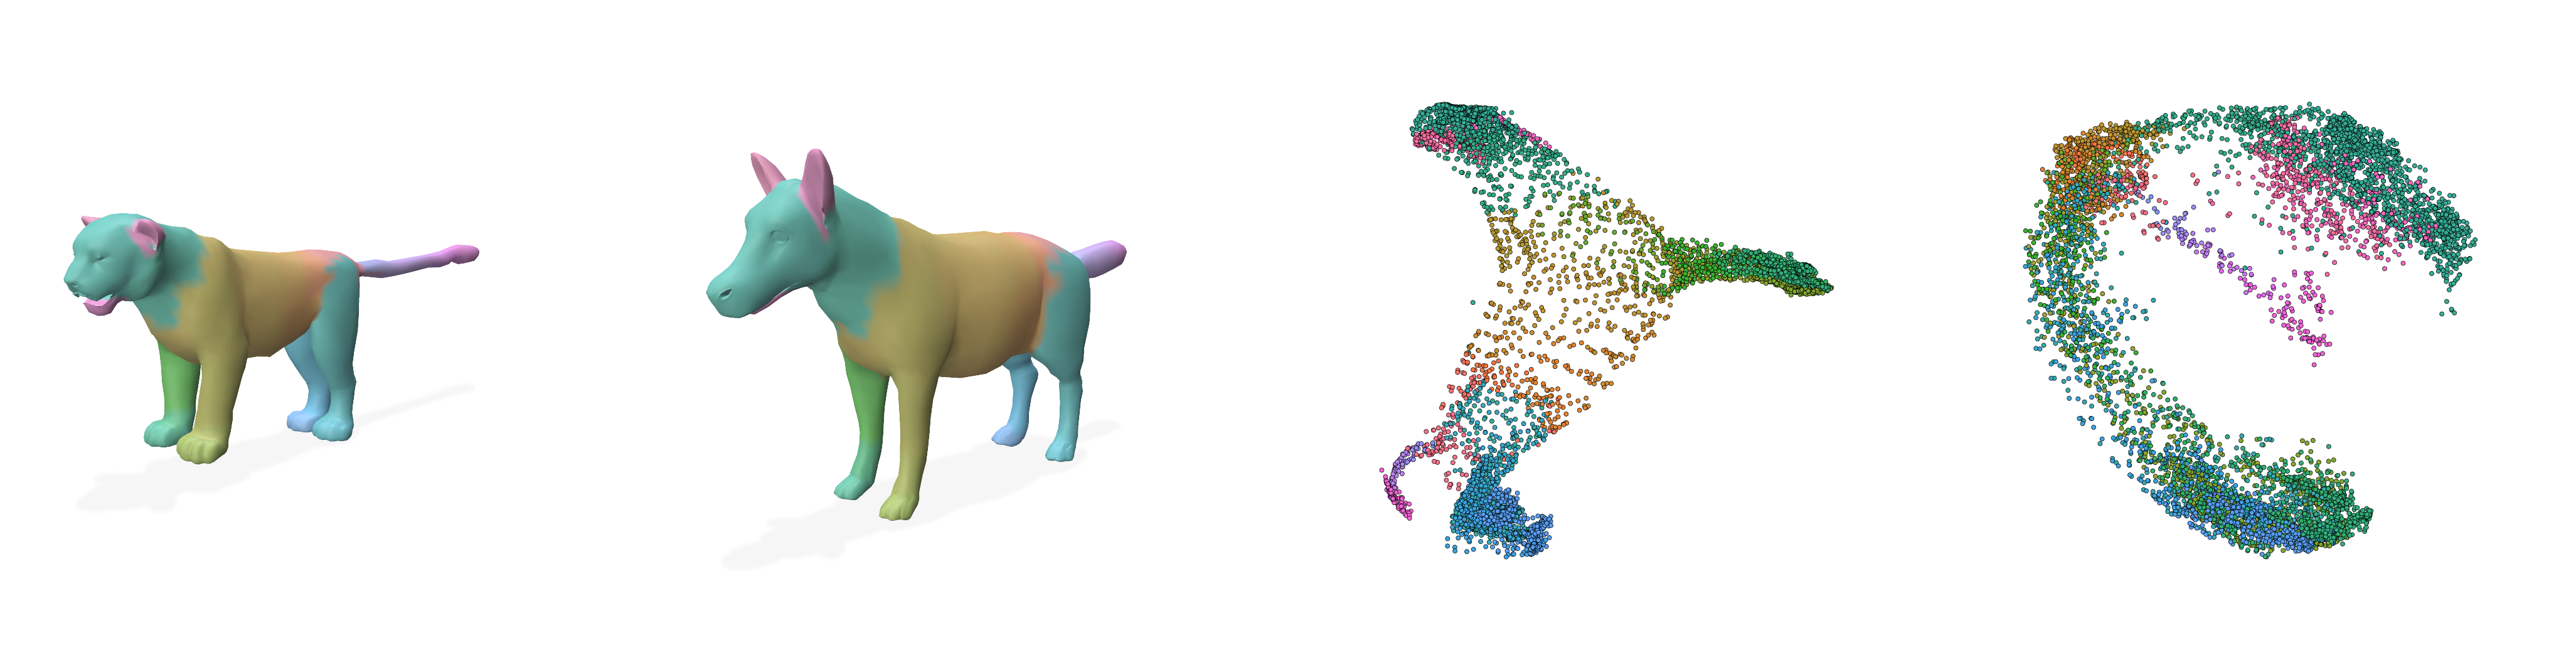

In [16]:
pca_name = 'smal_dummy'
make_labels = lambda x: torch.nn.functional.one_hot(x.argmax(-1), num_classes=x.shape[-1]).float()

pca_path = os.path.join(exp_path, 'pca')
os.makedirs(pca_path, exist_ok=True)

weights = make_labels(smal_weights).cpu().numpy()
_p = np.array(sns.husl_palette(weights.shape[-1]))

# Manually swap some colors around so the distinction between left and right becomes clear
p = _p.copy()
col = p[np.argmax(weights, axis=-1)]

indices = list(range(len(data_smal_dummy)))

plot_indices = [0, 1]

Fs = []
fs = []
cols = []
vertices = []
faces = []
plot_mask = []
for bi in indices:
    ver, fac, F, _, _, _, _ = data_smal_dummy[bi]
    vertices.append(ver)
    faces.append(fac)
    f = model_humans_animals.encode(F).detach()[:,0]
    F, f = F.cpu().numpy(), f.cpu().numpy()
    Fs.append(F)
    fs.append(f)
    cols.append(col)
    if bi in plot_indices:
        plot_mask += [True] * len(ver)
    else:
        plot_mask += [False] * len(ver)

plot_mask = np.array(plot_mask)
Fs = np.concatenate(Fs)
fs = np.concatenate(fs)

plot_kwargs = {
    "s":25, 
    "linewidths":0.5, 
    "edgecolors": 'black'
}
img_pca_ours, plt, fig = plot_pca_features_single(fs, np.concatenate(cols), plot_mask, **plot_kwargs)
plt.savefig(os.path.join(pca_path, f'{pca_name}_{str(plot_indices)}_ours.svg'), format="svg", transparent=True, bbox_inches='tight', pad_inches=0)
plt.close(fig)
img_pca_diff3f, plt, fig = plot_pca_features_single(Fs, np.concatenate(cols), plot_mask, **plot_kwargs)
plt.savefig(os.path.join(pca_path, f'{pca_name}_{str(plot_indices)}_diff3f.svg'), format="svg", transparent=True, bbox_inches='tight', pad_inches=0)
plt.close(fig)

imgs = [render(vertices[i].cpu().numpy(), faces[i].cpu().numpy(), cols[i], num_frames=1, pos = np.array([2, 0.5, 2])) for i in range(len(indices)) if i in plot_indices]

imgs = torch.cat([
    *imgs,
    torch.tensor(img_pca_ours, dtype=torch.float32).permute(2,1,0).flip(2)[None]/255., 
    torch.tensor(img_pca_diff3f, dtype=torch.float32).permute(2,1,0).flip(2)[None]/255.
    ], dim=0)


save_image(imgs, os.path.join(pca_path, f'{pca_name}_{str(plot_indices)}.png'))
print('Shape 1 | Shape 2 | PCA Ours | PCA Diff3F')
Image(os.path.join(pca_path, f'{pca_name}_{str(plot_indices)}.png'))

# Label Prediction
Based on pseudo label (skinning weights), we train a neural network to predict the labels on another shape

In [17]:
args.fps_p = 0
pred_dataset_name = 'smal_dummy'
args.mask = list(range(0,1)) # Train set, train on a single sample
data_train, weights = DATA[pred_dataset_name](args)

args.mask = list(range(1,5))  # Test set
data_test, weights = DATA[pred_dataset_name](args)
args.mask = None
skinning_model_ours, _ = train_skinning_weights_network(data_train, weights, model_humans_animals, epochs=200, ours=True, gamma=0.99, lr=1e-1)
skinning_model_diff3f, _ = train_skinning_weights_network(data_train, weights, model_humans_animals, epochs=200, ours=False, gamma=0.99, lr=1e-1)

100%|██████████| 200/200 [00:00<00:00, 3673.64it/s]


In [18]:
src_i_skinning = 1

sw_path = os.path.join(exp_path, 'skinning_weights_regression')
os.makedirs(sw_path, exist_ok=True)

error_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#f7f7f7", "#d73027"])
v_src, f_src, feat_src, Feat_src, _, _  = get_data(model_humans_animals, data_test, src_i_skinning)

pred_weights_ours = skinning_model_ours(feat_src).detach()
err_weights_ours = (pred_weights_ours - weights).pow(2).sum(dim=1)

pred_weights_diff3f = skinning_model_diff3f(Feat_src).detach()
err_weights_diff3f = (pred_weights_diff3f - weights).pow(2).sum(dim=1)

max_err = max(err_weights_ours.max(), err_weights_diff3f.max())
err_weights_ours = err_weights_ours / max_err
err_weights_diff3f  = err_weights_diff3f  / max_err

err_col_ours = error_cmap(err_weights_ours.cpu().numpy())[:,:3]
err_col_diff3f = error_cmap(err_weights_diff3f.cpu().numpy())[:,:3]

img_ours = render(v_src, f_src, err_col_ours, num_frames=120)
img_diff3f = render(v_src, f_src, err_col_diff3f, num_frames=120)
skinning_path = os.path.join(sw_path, f'{src_i_skinning}')

save_video_and_frames([img_ours, img_diff3f], skinning_path, loop=False)

print('Error Ours', (pred_weights_ours - weights).pow(2).mean().item())
print('Error Diff3F', (pred_weights_diff3f - weights).pow(2).mean().item())
print('Ours | Diff3F')
play_folder(skinning_path)

[libx264 @ 0x8d64cc0] -qscale is ignored, -crf is recommended.


Error Ours 0.003312899963930249
Error Diff3F 0.00719473697245121
Ours | Diff3F


# Pose Alignment
Based on the semantic correspondences, we can fit kinematic models to shape without a kinematic model. In this example, we are aligning SMAL models to two animal statues from Polyhaven.

In [4]:
idx_src = 2
idx_tgt = 0

pose_fitting_path = os.path.join(exp_path, 'pose_fitting', f"smal_to_polyhaven_animals", f"source{idx_src}_target{idx_tgt}")
os.makedirs(pose_fitting_path, exist_ok=True)

do_video_comparison(args, model_humans_animals, data_smal_dummy, data_animals, idx_src=idx_src, idx_tgt=idx_tgt, 
                    save_path=pose_fitting_path, p=1, init_iters=1500, iters=5000, num_err_imgs=0, model_type="SMAL", cam_pos=[3, 1.5, -2], 
                    fit_betas=False, w_arap=1, skip_sequence=True)
print('Ours Source | Target + Our Correspondences | Diff3F | Target + Diff3F Correspondences')
play_folder(pose_fitting_path)

100%|██████████| 5001/5001 [01:08<00:00, 73.26it/s]
[libx264 @ 0x42c01bc0] -qscale is ignored, -crf is recommended.


Ours Source | Target + Our Correspondences | Diff3F | Target + Diff3F Correspondences


## Pose Fitting based on Animated meshes
This requires you to set up the DT4D dataset.

In [5]:
name_src = 'smal_dummy'
name_tgt = 'dt4d'
data_smal_ours, _ = DATA[name_src](args)
data_dt4d, _ = DATA[name_tgt](args)

idx_src = 1 # dog

p = 0.1
for idx_tgt in [6, 216]:
    pose_fitting_path = os.path.join(exp_path, 'pose_fitting', f"{name_src}_to_{name_tgt}",f"source{idx_src}_target{idx_tgt}", f"p{p}")
    os.makedirs(pose_fitting_path, exist_ok=True)

    do_video_comparison(args, model_humans_animals, data_smal_ours, data_dt4d, idx_src=idx_src, idx_tgt=idx_tgt, save_path=pose_fitting_path, p=p, init_iters=1500, iters=5000, num_err_imgs=0, model_type="SMAL", cam_pos=[3, 1.5, -2], skip_pose=True)
    play_folder(pose_fitting_path)

100%|██████████| 5001/5001 [01:05<00:00, 76.85it/s]
[libx264 @ 0x3193cbc0] -qscale is ignored, -crf is recommended.


100%|██████████| 5001/5001 [01:54<00:00, 43.52it/s]
[libx264 @ 0x3e8d5bc0] -qscale is ignored, -crf is recommended.


In [5]:
list(zip(data_dt4d.sequences, range(len(data_dt4d.sequences))))

[('bear3EP_Idle3', 0),
 ('bear3EP_TrotrightRM', 1),
 ('bear3EP_Rotate90R', 2),
 ('bear3EP_Lie', 3),
 ('bear3EP_JumptrotRM', 4),
 ('bear9AK_HideRotL', 5),
 ('bear9AK_Attack4', 6),
 ('bear9AK_Idle2', 7),
 ('bear9AK_CrouchforwardRM', 8),
 ('bear9AK_JumprunRM', 9),
 ('bear84Q_SwimbackLRM', 10),
 ('bear84Q_CrouchbaclRRM', 11),
 ('bear84Q_WalkhuntedRM', 12),
 ('bear84Q_Hitfront', 13),
 ('bear84Q_FlyRM', 14),
 ('bearPDD_Idlerotate45LRM', 15),
 ('bearPDD_attackrunRM', 16),
 ('bearPDD_trotforwardRM', 17),
 ('bearPDD_IdlerotateRRM', 18),
 ('bearPDD_Hitsimple', 19),
 ('bearVGG_Run2', 20),
 ('bearVGG_Fall2', 21),
 ('bearVGG_Damaged5', 22),
 ('bearVGG_Idle9', 23),
 ('bearVGG_Sleep1', 24),
 ('bucksYJL_Idle6', 25),
 ('bucksYJL_Fall2', 26),
 ('bucksYJL_GetHit0', 27),
 ('bucksYJL_WalkBack0', 28),
 ('bucksYJL_Death0', 29),
 ('bullMJ6_Turn180L', 30),
 ('bullMJ6_Falllanding', 31),
 ('bullMJ6_WalkF', 32),
 ('bullMJ6_Hitfront', 33),
 ('bullMJ6_RunL', 34),
 ('bunnyQ_RotateR', 35),
 ('bunnyQ_Eat', 36),
 ('bun